# スラックの人のやつそのまま版＋データ探索

---

In [ ]:
!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 5.8 MB/s eta 0:00:00


In [ ]:
!pip install category_encoders


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.9 MB/s eta 0:00:00


In [ ]:
import unicodedata #Pythonの標準ライブラリで、Unicodeデータベースにアクセスするためのモジュールです。文字のカテゴリ、名前、デコードされた値などの情報を取得するために使用されます。
from pathlib import Path #Pythonの標準ライブラリで、ファイルシステムのパスを操作するためのモジュールです。ファイルやディレクトリの操作を簡単に行うためのオブジェクト指向のインターフェースを提供します。

import catboost as cb #Yandexが開発した高速な勾配ブースティングライブラリです。カテゴリ変数の自動エンコーディング機能を持つため、特にカテゴリ変数を多く含むデータセットで優れた性能を発揮します。
import lightgbm as lgb #Microsoftが開発した高速な勾配ブースティングライブラリです。大規模なデータセットでも高速に学習できるように設計されており、特にランク学習や多クラス分類に優れています。
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import CountEncoder #カウントエンコーディングを行うためのエンコーダです。カテゴリ変数の各値の出現回数をエンコードするために使用されます。
from sklearn.base import BaseEstimator, TransformerMixin #scikit-learnの基本クラスで、独自の推定器や変換器を作成する際のベースとなるクラスです。
from sklearn.compose import ColumnTransformer #複数の特徴変換を一つの変換器としてまとめるためのクラスです。異なる列に異なる変換を適用するために使用されます。
from sklearn.metrics import mean_absolute_percentage_error #MAPE（Mean Absolute Percentage Error）を計算するための関数です。予測誤差の平均的な割合を評価するために使用されます。
from sklearn.model_selection import KFold #K-分割交差検証を行うためのクラスです。データセットをK個のフォールドに分割し、モデルの訓練と評価を繰り返すために使用されます。
from sklearn.pipeline import Pipeline #複数の変換ステップを一つの推定器としてまとめるためのクラスです。データの前処理とモデルの訓練を一連のステップとして定義するために使用されます。
from category_encoders import TargetEncoder #ターゲットエンコーディングを行うためのエンコーダです。カテゴリ変数の各値をターゲット変数の平均値にエンコードするために使用されます。


In [ ]:
#INPUT_DIR = Path("data/") ←これでパスを省略できる！

In [ ]:
# train_df = pd.read_csv(INPUT_DIR / "train.csv")
# test_df = pd.read_csv(INPUT_DIR / "test.csv")
# sub_df = pd.read_csv(INPUT_DIR / "submit_sample.csv", names=["id", "price"])
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sub_df = pd.read_csv("submit_sample.csv", names=["id", "price"]) #このデータフレームは、提出する予測結果を保持します。names=["id", "price"]という引数は、CSVファイルの列名を指定するためのものです。この場合、"id"と"price"という名前の列が存在すると想定されています。

## 前処理

In [ ]:
class PreProcessTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None): #機械学習のトランスフォーマーまたはモデルをトレーニングデータに適合させるために使用される。この場合は何も指定されてないためそのまま
        return self

    def transform(self, X):
        # cylinderから数値を取り出す
        X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").astype("float64") #数値を抽出し、float32型に変換

        # sizeの表記揺れを修正
        X["size"] = X["size"].str.replace("ー", "-").astype(str) #特定の文字（"ー"や"−"）を"-"に置換
        X["size"] = X["size"].str.replace("−", "-").astype(str)

        # manufacturerの表記揺れを修正
        X["manufacturer"] = X["manufacturer"].apply(
            lambda x: unicodedata.normalize("NFKC", x).lower() #すべての文字を小文字に変換し、Unicode正規化を行っています。
        )

        # yearが3000年以降のものはおかしいので2000年に置換
        err_idx = X.query("year >= 3000").index
        X.loc[err_idx, "year"] = X.loc[err_idx, "year"].apply(lambda x: x - 1000) #誤った年数から1000を引いて置換しています。

        # 走行距離 / 製造年
        X["odometer_per_year"] = X["odometer"] / (2023 - X["year"]) #これは、走行距離（odometer）を車の年齢（2023 - year）で割った値です。

        return X #変換後のデータフレームを返します。


In [ ]:
class RankTransformer(TransformerMixin, BaseEstimator):
    """keyの中でvalueが何番目のものか"""

    def __init__(self, key: str, value: str):
        self.key = key
        self.value = value #トランスフォーマーを初期化する際に、2つの引数keyとvalueを受け取ります。これらは、ランク付けを行うための列の名前です。keyはグループ化のための列名、valueはランク付けの対象となる列名を指定します。

    def fit(self, X, y=None):
        return self #入力データを変更せずにそのまま返します。

    def transform(self, X):
        X_new = X.copy()
        X_new[self.key] = X_new.groupby(self.key)[self.value].rank(method="dense") #このメソッドでは、keyで指定された列を基に、valueで指定された列の値をランク付けします。ランク付けの方法として、method="dense"が指定されているため、同じ値の要素には同じランクが付けられ、ランクが欠けることはありません。
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self, input_features=None): #get_feature_names_outメソッド:このメソッドは、出力される特徴の名前を返すために使用されます。このトランスフォーマーでは、keyで指定された列名が返されます。
        return [self.key]

  #このトランスフォーマーを使用することで、特定のキーに基づいて値をランク付けすることができます。これは、グループごとの相対的な順序付けを行う際に有用

In [ ]:
class OriginalTransformer(TransformerMixin, BaseEstimator):
    """数値特徴はそのまま、カテゴリ特徴はcategory型に変換"""

    def __init__(self, numeric_cols, categorical_cols): #トランスフォーマーを初期化する際に、2つの引数numeric_colsとcategorical_colsを受け取ります。これらは、数値型の列とカテゴリ型の列の名前を指定するためのリストです。
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None): #入力データを変更せずにそのまま返します。
        return self

    def transform(self, X):
        X_new = X.copy()#データの変換を行うために使用されます。

        # 数値変数
        X_new[self.numeric_cols] = X_new[self.numeric_cols].astype("float64")#numeric_colsで指定された列をfloat64型に変換します。これにより、数値型のデータが浮動小数点数として扱われます。

        # カテゴリ変数
        X_new[self.categorical_cols] = X_new[self.categorical_cols].astype("category")#categorical_colsで指定された列をcategory型に変換します。これにより、カテゴリ型のデータが効率的にエンコードされます。

        return X_new[self.get_feature_names_out()] #このメソッドは、出力される特徴の名前を返すために使用されます。このトランスフォーマーでは、numeric_colsとcategorical_colsの両方の列名が返されます。

    def get_feature_names_out(self):
        return self.numeric_cols + self.categorical_cols


In [ ]:
class CountTransformer(TransformerMixin, BaseEstimator):
    """CountEncoder"""

    def __init__(self): #初期化時に特定の引数を受け取らないので、passが記述されています。
        pass

    def fit(self, X, y=None):
        self.ce = CountEncoder(cols=X.columns.tolist(), handle_unknown=0) #CountEncoderをインスタンス化して、データに適合させます。CountEncoderは、カテゴリ変数の各値の出現回数をエンコードするためのエンコーダです。ここでは、全ての列をエンコードするために、colsパラメータにX.columns.tolist()を渡しています。また、handle_unknownパラメータに0を渡して、未知のカテゴリが出現した場合には0を返すようにしています。
        self.ce.fit(X)
        return self

    def transform(self, X):
        return self.ce.transform(X) #このメソッドは、データの変換を行うために使用されます。このメソッドでは、fitメソッドで適合させたCountEncoderを使用して、データをカウントエンコーディングします。

    def get_feature_names_out(self, input_features=None): #出力される特徴の名前を返すために使用されます。このトランスフォーマーでは、入力された特徴の名前をそのまま返しています。
        return input_features

In [ ]:
class AggTransformer(TransformerMixin, BaseEstimator):#TransformerMixinおよびBaseEstimatorクラスを継承しています。このトランスフォーマーは、指定されたキーに基づいて数値列を集約するために使用されます。
    """集約特徴量"""

    def __init__(self, key, numeric_cols, agg_func: dict): #トランスフォーマーを初期化する際に、3つの引数key、numeric_cols、agg_funcを受け取ります。
        self.key = key#key: 集約のキーとして使用する列の名前です。
        self.numeric_cols = numeric_cols#numeric_cols: 集約する数値列の名前を指定するためのリストです
        self.agg_func = agg_func#agg_func: 集約関数を指定するための辞書です。キーは集約関数の名前、値は適用す

    def fit(self, X, y=None):
        X = X.copy()
        X[self.key] = X[self.key].astype("category")#入力データのkey列をcategory型に変換します。
        self.agg_df = X.groupby(self.key)[self.numeric_cols].agg(self.agg_func)#入力データをkey列でグループ化し、numeric_colsの列に対してagg_funcで指定された集約関数を適用します。
        self.agg_df.columns = [f"{col}_{func}" for col, func in self.agg_df.columns.tolist()]#集約結果の列名を、元の列名と集約関数の名前を組み合わせた形に変更します。

        return self

    def transform(self, X): #データの変換を行う
        X_new = pd.merge(X, self.agg_df, on=self.key, how="left") #入力データとfitメソッドで作成された集約データをkey列で結合します。
        return X_new[self.get_feature_names_out()] #集約データの列のみを出力として返します。

    def get_feature_names_out(self, input_features=None): #このメソッドは、出力される特徴の名前を返すために使用されます。このトランスフォーマーでは、集約データの列名をそのまま返しています。
        return self.agg_df.columns.tolist()

In [ ]:
numeric_cols = ["year", "odometer", "odometer_per_year"] #数値とカテゴリの列を指定しています。numeric_colsには数値の列が、categorical_colsにはカテゴリの列が含まれています。
categorical_cols = [
    #  'region',
    "cylinders",
    "manufacturer",
    "condition",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    "state",
]

ct = ColumnTransformer( #ColumnTransformerを使用して、複数のトランスフォーマーをまとめています。これにより、異なる列に異なる前処理を適用できます
    transformers=[
        (
            "ori",
            OriginalTransformer(numeric_cols, categorical_cols), #OriginalTransformerは、数値変数をfloat32型に変換し、カテゴリ変数をcategory型に変換します。
            categorical_cols + numeric_cols,
        ),
        (
            "tgt",
            TargetEncoder(), #TargetEncoderは、カテゴリ変数をターゲット変数の平均値に基づいてエンコードします。
            [
                # 'region',
                "cylinders",
                "manufacturer",
                "condition",
                "fuel",
                "title_status",
                "transmission",
                "drive",
                "size",
                "type",
                "paint_color",
                "state",
            ],
        ),
        # *[
        #     (f"agg_{key}", AggTransformer(key, ["odometer"], {"mean"}), [key] + ["odometer"])    AggTransformerを使用して、指定されたキーに基づいて数値列を集約することができます。
        #     for key in [
        #         "manufacturer",
        #     ]
        # ],
    ],
    verbose=True,
)
ct.set_output(transform="pandas") #ColumnTransformerの出力をpandas形式に設定
pipe = Pipeline(  #Pipelineを使用して、前処理ステップをまとめています。ここでは、2つのステップが含まれています。
    steps=[
        ("preprocess", PreProcessTransformer()),  #preprocessステップでは、PreProcessTransformerを使用して、データの初期の前処理を行います。
        ("ct", ct),  #ctステップでは、先に定義したColumnTransformerを使用して、特定の列に対して前処理を行います。
    ]
)
train_feat_df = pipe.fit_transform(train_df, train_df["price"]) #fit_transformメソッドを使用して、訓練データを変換し、transformメソッドを使用して、テストデータを変換しています。
test_feat_df = pipe.transform(test_df)


[ColumnTransformer] ........... (1 of 2) Processing ori, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing tgt, total=   0.5s


In [ ]:
train_feat_df.sample(5)

,ori__year,ori__odometer,ori__odometer_per_year,ori__cylinders,ori__manufacturer,ori__condition,ori__fuel,ori__title_status,ori__transmission,ori__drive,...,tgt__manufacturer,tgt__condition,tgt__fuel,tgt__title_status,tgt__transmission,tgt__drive,tgt__size,tgt__type,tgt__paint_color,tgt__state
3001,2008.0,346851.0,23123.400000,8.0,ram,excellent,gas,clean,manual,4wd,...,24430.690665,14662.392076,12251.696042,13276.948312,12058.838856,18647.268281,15395.125786,13821.113801,11324.398140,13645.713546
10521,2006.0,147587.0,8681.588235,4.0,toyota,good,gas,clean,automatic,fwd,...,9206.552189,11022.550674,12251.696042,13276.948312,13944.440064,9810.263663,15395.125786,20267.473808,8627.553878,9988.219424
23997,1999.0,33365.0,1390.208333,8.0,chevrolet,excellent,gas,clean,automatic,rwd,...,14994.540583,14662.392076,12251.696042,13276.948312,13944.440064,15846.747621,12158.408777,14083.732481,16884.879139,13346.485836
18757,1997.0,190918.0,7343.000000,8.0,ram,good,gas,clean,manual,4wd,...,24430.690665,11022.550674,12251.696042,13276.948312,12058.838856,18647.268281,15395.125786,20267.473808,11324.398140,12537.433333
13970,2017.0,75299.0,12549.833333,4.0,nissan,like new,gas,clean,automatic,fwd,...,10014.547000,16511.362730,12251.696042,13276.948312,13944.440064,9810.263663,15395.125786,9939.633654,13542.542629,13726.955811


## モデル構築

In [ ]:
#LightGBMとCatBoostモデルを訓練するための関数、特徴量の重要度を可視化するための関数、そして予測と実際の目標値を比較するための関数が含まれています
def get_cv(df, n_fold=5):
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=71)
    return list(kf.split(df))
#↑この関数は、5分割交差検証を行うためのインデックスを返します。データセットdfをランダムに5つのフォールドに分割し、各フォールドが一度だけ検証データとして使用されるようにします。戻り値は、訓練データと検証データのインデックスのリストです。



# ref: https://www.guruguru.science/competitions/16/discussions/185c7dc6-5e3a-49c6-9c30-41bf007cc694/
def fit_lgbm(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50): #この関数は、LightGBMを使用して回帰モデルを訓練します。
    # パラメータがないときは、空の dict で置き換える
    if params is None: #params: LightGBMのモデルパラメータの辞書。
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv): #cv: 交差検証のインデックス。get_cv関数で得られたものを使用します。
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            x_train,
            y_train,
            categorical_feature=categorical_cols, #categorical_cols: カテゴリ変数の列名のリスト。
            eval_set=[(x_valid, y_valid)],
            callbacks=[lgb.early_stopping(100, verbose=verbose)], #verbose: ログ出力の頻度
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models
    #この関数は、交差検証の各フォールドでモデルを訓練します。訓練データと検証データが指定され、LightGBMのLGBMRegressorクラスを使用してモデルを訓練します。
    #この関数は、各フォールドでのOOF予測を行い、訓練されたモデルを保存します。MAPE（平均絶対パーセンテージ誤差）を計算して、各フォールドでのスコアを表示します。
    #この関数の戻り値は、全体のMAPEスコア、OOF予測、および訓練されたモデルのリストです。


In [ ]:
#CatBoostを使った回帰モデルの訓練を行う関数を含んでいます。具体的には、fit_cat関数が定義されています。この関数は、交差検証を使ってモデルを訓練し、Out-of-Fold (OOF) 予測を行います
def fit_cat(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50): #CatBoostを使用して回帰モデルを訓練します
#cv: 交差検証のインデックス。categorical_cols: カテゴリ変数の列名のリスト。params: CatBoostのモデルパラメータの辞書。verbose: ログ出力の頻度。
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = cb.CatBoostRegressor(**params) #交差検証の各フォールドでモデルを訓練します。訓練データと検証データが指定され、CatBoostのCatBoostRegressorクラスを使用してモデルを訓練します。
        model.fit(
            x_train,
            y_train,
            cat_features=categorical_cols,#モデルの訓練中に、カテゴリ変数の列が指定されると、CatBoostは自動的にカテゴリ変数のエンコーディングを行います。
            eval_set=[(x_valid, y_valid)],
            use_best_model=True,
            early_stopping_rounds=100,
            verbose=verbose,
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}") #この関数は、各フォールドでのOOF予測を行い、訓練されたモデルを保存します。MAPE（平均絶対パーセンテージ誤差）を計算して、各フォールドでのスコアを表示します。

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models #この関数の戻り値は、全体のMAPEスコア、OOF予測、および訓練されたモデルのリストです。

In [ ]:

# optunaを使ったパラメータチューニング
# def tuning(train_feat_df, train_df, cv):
#     def objective(trial):
#         max_depth = trial.suggest_int("max_depth", 1, 10)
#         num_leaves = trial.suggest_int("num_leaves", 2, 2**max_depth)
#         colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
#         subsample = trial.suggest_uniform("subsample", 0.1, 1.0)

#         params = {
#             "objective": "mape",
#             "n_estimators": 10000,
#             "learning_rate": 0.05,
#             "max_depth": max_depth,
#             "num_leaves": num_leaves,
#             "colsample_bytree": colsample_bytree,
#             "subsample": subsample,
#             "metric": "mape",
#             "importance_type": "gain",
#             "random_state": 88,
#         }

#         score, _, _ = fit_lgbm(
#             train_feat_df, train_df["price"], cv=cv, categorical_cols=[], params=params, verbose=-1
#         )
#         return score

#     study = optuna.create_study(direction="minimize")
#     study.optimize(objective, n_trials=100)
#     print("Number of finished trials:", len(study.trials))
#     print("Best trial:", study.best_trial.params)
#     return study.best_trial.params



## 特徴を可視化

In [ ]:
#複数のモデルの特徴重要度を視覚化するためのものです。特徴重要度は、モデルが予測にどの特徴を重視しているかを示す指標です。具体的には、特徴が予測にどれだけ寄与しているかを数値で示します。
def visualize_importance(models, feat_train_df): #この関数は、訓練されたモデルの特徴重要度を視覚化します。
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models): #models: 訓練されたモデルのリスト。
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_ #feat_train_df: 訓練データの特徴量を含むDataFrame
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True) #特徴重要度を格納するDataFrame。各行は1つの特徴に対する重要度を示します。
    #_df: 各モデルの特徴重要度を一時的に格納するDataFrame。

    order = ( #重要度が高い特徴を抽出するために、orderを計算します。これは、特徴重要度の合計が高い上位50の特徴を抽出するためのものです。
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot( #sns.boxenplotを使用して、特徴重要度を視覚化します。これにより、重要度が高い特徴がどれかを一目で確認できます。
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax #この関数は、作成したプロットのfigとaxを返します。

    #この関数を使用することで、モデルがどの特徴を重視しているかを視覚的に確認できます。これは、特徴選択や特徴エンジニアリングの方針を決定する際に役立ちます。

In [ ]:
def visualize_oof_gt(oof, gt): #この関数は、Out of Fold (OOF) の予測値と実際の目的変数 (Ground Truth, GT) の値を散布図で表示します。OOF予測は、交差検証の各分割で検証データに対する予測値の集合です。
#予測値と実際の値がどれだけ一致しているかを視覚的に評価するためのものです。
#oof: OOFの予測値
#gt: 実際の目的変数の値 (Ground Truth)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(oof, gt, alpha=0.5)
    gt_max = gt.max()
    ax.plot(np.arange(0, gt_max), np.arange(0, gt_max), color="red", alpha=0.5, linestyle="--")
    ax.set_xlabel("Out Of Fold")
    ax.set_ylabel("Ground Truth")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax
    #関数は、散布図を作成し、赤い点線でy=xの直線を表示します。これは、完全な一致を示す線です。プロット上の点がこの線に近いほど、予測が実際の値に近いことを示します。



def visualize_oof_pred(oof, pred): #この関数は、OOFの予測値とテストデータの予測値の分布をヒストグラムで表示します。
#この関数は、OOF予測とテスト予測の分布がどれだけ一致しているかを視覚的に評価するためのものです。
#oof: OOFの予測値
#pred: テストデータの予測値
    fig, ax = plt.subplots(figsize=(8, 6))

    bins = 100
    ax.hist(pred, bins=bins, density=True, alpha=0.5, label="Test")
    ax.hist(oof, bins=bins, density=True, alpha=0.5, label="OutOfFold")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax
    #関数は、2つのヒストグラムを重ねて表示します。OOF予測のヒストグラムは青で、テスト予測のヒストグラムはオレンジで表示されます。これにより、2つの分布の一致度を視覚的に確認できます。

    #これらの関数は、モデルの評価や予測の確認に役立ちます。予測値と実際の値の散布図や、OOF予測とテスト予測の分布のヒストグラムを視覚的に確認することで、モデルの品質を評価できます。


In [ ]:
n_fold = 5 #交差検証のためにデータを5分割します。
lgbm_params = { #LightGBMモデルのパラメータを定義しています。ここで定義したパラメータは、モデルの訓練時に使用されます。
    "objective": "mape",
    "metrics": "mape",
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "max_depth": 5,
    "num_leaves": 32,
    "colsample_bytree": 0.446,
    "subsample": 0.339,
    "importance_type": "gain",
    "random_state": 88,
}

feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist() #訓練データフレームのカテゴリ変数の列名を取得しています。

cv = get_cv(train_feat_df, n_fold=5) #交差検証のためのデータ分割を取得しています。get_cv関数は先に定義されていた関数です。

# training
score, oof, models = fit_lgbm( #fit_lgbm関数を使用してLightGBMモデルを訓練しています。この関数は先に定義されており、交差検証を使用してモデルの訓練を行い、Out-of-Fold (OOF) の予測値を返します。
    train_feat_df,
    y=train_df["price"],
    categorical_cols=[],
    params=lgbm_params,
    cv=cv,
    verbose=False,
)

# inference
pred = np.array([model.predict(test_feat_df) for model in models]) #交差検証で訓練された各モデルを使用して、テストデータの予測を行います。
pred = np.mean(pred, axis=0) #テストデータの予測値を平均して、最終的な予測値を取得します。

# submission
sub_df["price"] = pred #提出用のデータフレームsub_dfのprice列に予測値を代入します。
sub_df.to_csv("submission.csv", index=False, header=False) #提出用のデータフレームをCSVファイルとして保存します。このファイルはコンペティションの提出用です。


#このコードは、LightGBMを使って予測モデルを訓練し、テストデータで予測を行い、結果を提出用のCSVファイルに保存するための一連の処理を行っています。

ストリーミング出力は最後の 5000 行に切り捨てられました。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

## モデル特徴可視化

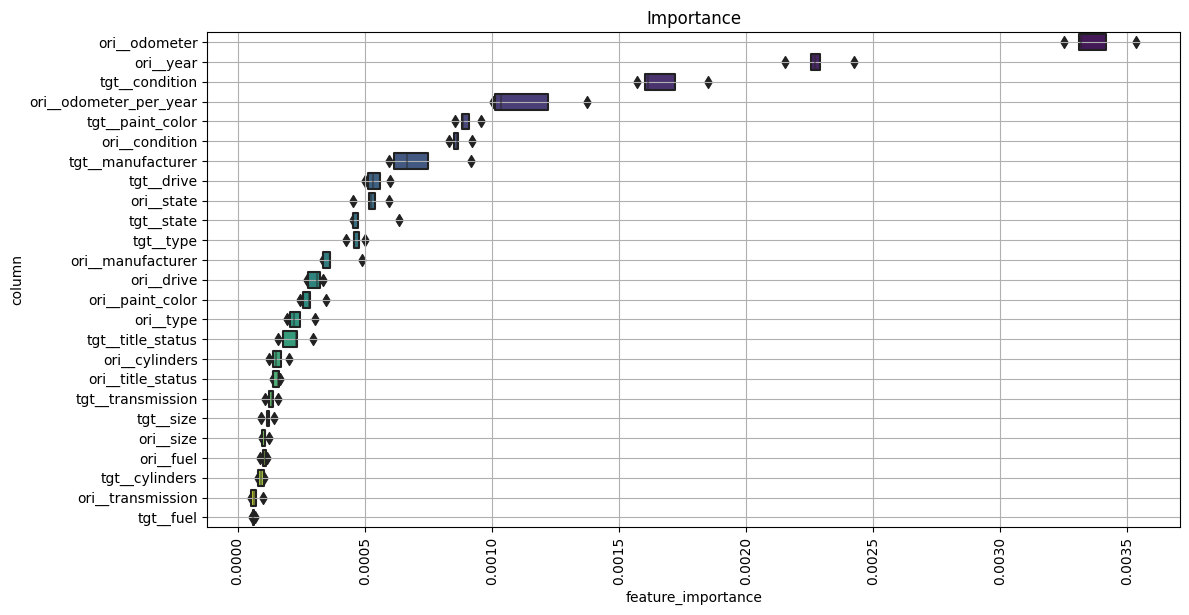

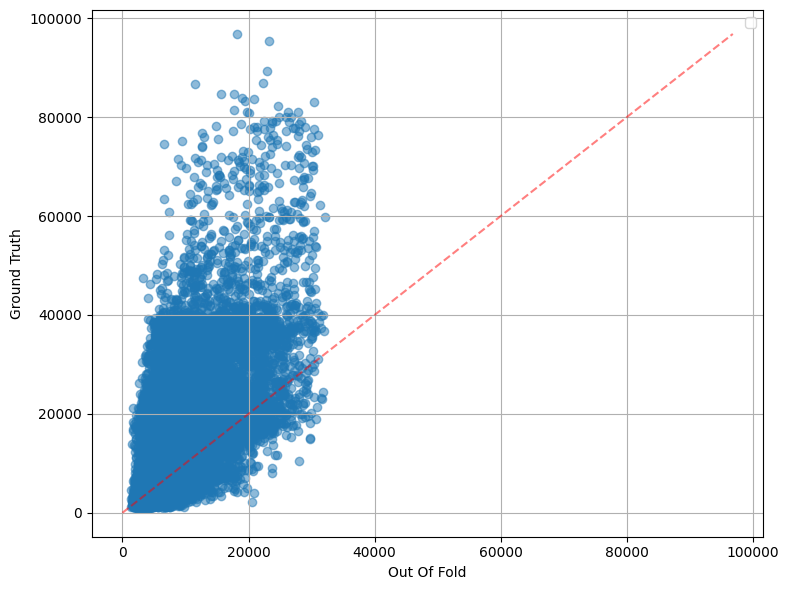

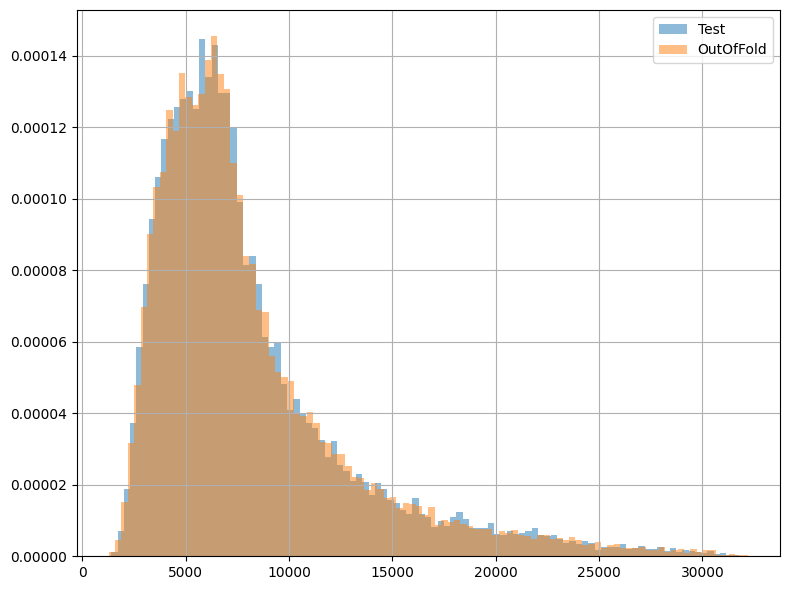

In [ ]:
#このコードは、先に定義された可視化用の関数を使って、モデルの重要度、OOF（Out-of-Fold）予測と実際の値、テストデータの予測を可視化しています。具体的には：
visualize_importance(models, train_feat_df) #モデルの特徴重要度を可視化します。 modelsは訓練されたモデルのリスト、train_feat_dfは訓練データフレームです。
visualize_oof_gt(oof, train_df['price']) #OOF（Out-of-Fold）予測と実際の値を散布図で可視化します。oofはOOF予測値、train_df['price']は実際の値です。この関数は、モデルがどれだけ実際の値に近い予測をしているかを把握するのに役立ちます。
visualize_oof_pred(oof, pred) #テストデータの予測とOOF予測のヒストグラムを可視化します。oofはOOF予測値、predはテストデータの予測値です。この関数は、テストデータの予測とOOF予測の分布を比較するのに役立ちます。
#これらの関数は、モデルの評価や特徴の重要度を把握するための可視化を提供します。これにより、モデルのパフォーマンスを評価し、特徴選択やパラメータチューニングの方針を決定するのに役立ちます。

In [ ]:
# Initialize a list to store the comparison results
comparison_results = []

# Loop through the validation folds
for i, (idx_train, idx_valid) in enumerate(cv):
    x_valid, y_valid = train_feat_df.iloc[idx_valid], train_df.iloc[idx_valid]["price"]
    pred_i = models[i].predict(x_valid)
    # Store the comparison results in the list
    comparison_results.append(pd.DataFrame({'Actual Price': y_valid, 'Predicted Price': pred_i}))

# Concatenate the comparison results into a single dataframe
comparison_df = pd.concat(comparison_results, axis=0)

# Display the comparison dataframe
print(comparison_df)


       Actual Price  Predicted Price
1              4724      3727.865829
2             10931      3254.156212
3             16553      8472.940192
9              7341      4151.390405
13             8760      7922.729654
...             ...              ...
27511         19409      8311.999296
27515         37020     10924.077037
27517          8853      6454.230395
27520          6959      3971.626277
27526          6602      6898.757613

[27532 rows x 2 columns]


       Actual Price  Predicted Price
1              4724           3727.9
2             10931           3254.2
3             16553           8472.9
9              7341           4151.4
13             8760           7922.7
...             ...              ...
27511         19409           8312.0
27515         37020          10924.1
27517          8853           6454.2
27520          6959           3971.6
27526          6602           6898.8

[27532 rows x 2 columns]


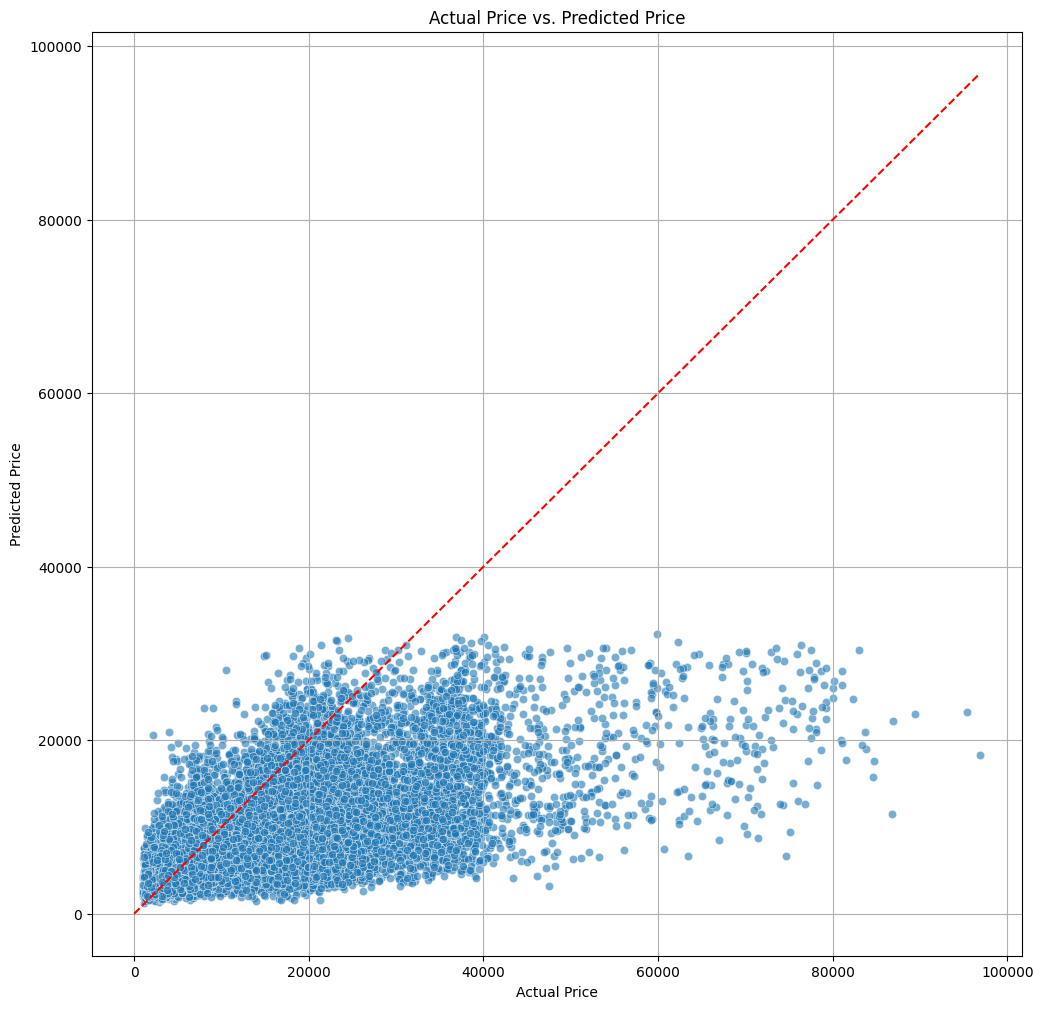

In [ ]:
# Round the predicted prices to one decimal place
comparison_df['Predicted Price'] = comparison_df['Predicted Price'].round(1)

# Display the comparison dataframe
print(comparison_df)

# Plot the actual prices vs. predicted prices
plt.figure(figsize=(12, 12))
sns.scatterplot(data=comparison_df, x='Actual Price', y='Predicted Price', alpha=0.6)
plt.plot([0, max(comparison_df['Actual Price'])], [0, max(comparison_df['Actual Price'])], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Price vs. Predicted Price')
plt.grid(True)
plt.show()


In [ ]:
# Calculate the absolute difference between actual and predicted prices
comparison_df['Absolute Difference'] = abs(comparison_df['Actual Price'] - comparison_df['Predicted Price'])

# Sort the dataframe by the absolute difference in descending order
sorted_comparison_df = comparison_df.sort_values(by='Absolute Difference', ascending=False)

# Pick up the top 5000 records with the largest absolute difference
top_diff_df = sorted_comparison_df.head(5000)

# Merge the top_diff_df with the original train_df to get the features of the picked records
picked_records_df = pd.merge(top_diff_df, train_df, left_index=True, right_index=True)

# Display the features of the picked records
print(picked_records_df)


       Actual Price  Predicted Price  Absolute Difference     id  \
16550         96818          18239.6              78578.4  16550   
11003         86736          11475.8              75260.2  11003   
6251          95329          23286.5              72042.5   6251   
6971          84636          15707.7              68928.3   6971   
3487          74647           6646.5              68000.5   3487   
...             ...              ...                  ...    ...   
13714         20633           8565.3              12067.7  13714   
20264         19404           7336.9              12067.1  20264   
8715          20111           8046.3              12064.7   8715   
18976         24516          12456.6              12059.4  18976   
4110          18302           6243.1              12058.9   4110   

                         region  year manufacturer  condition  cylinders  \
16550                  lakeland  2016    chevrolet  excellent        8.0   
11003                     maine

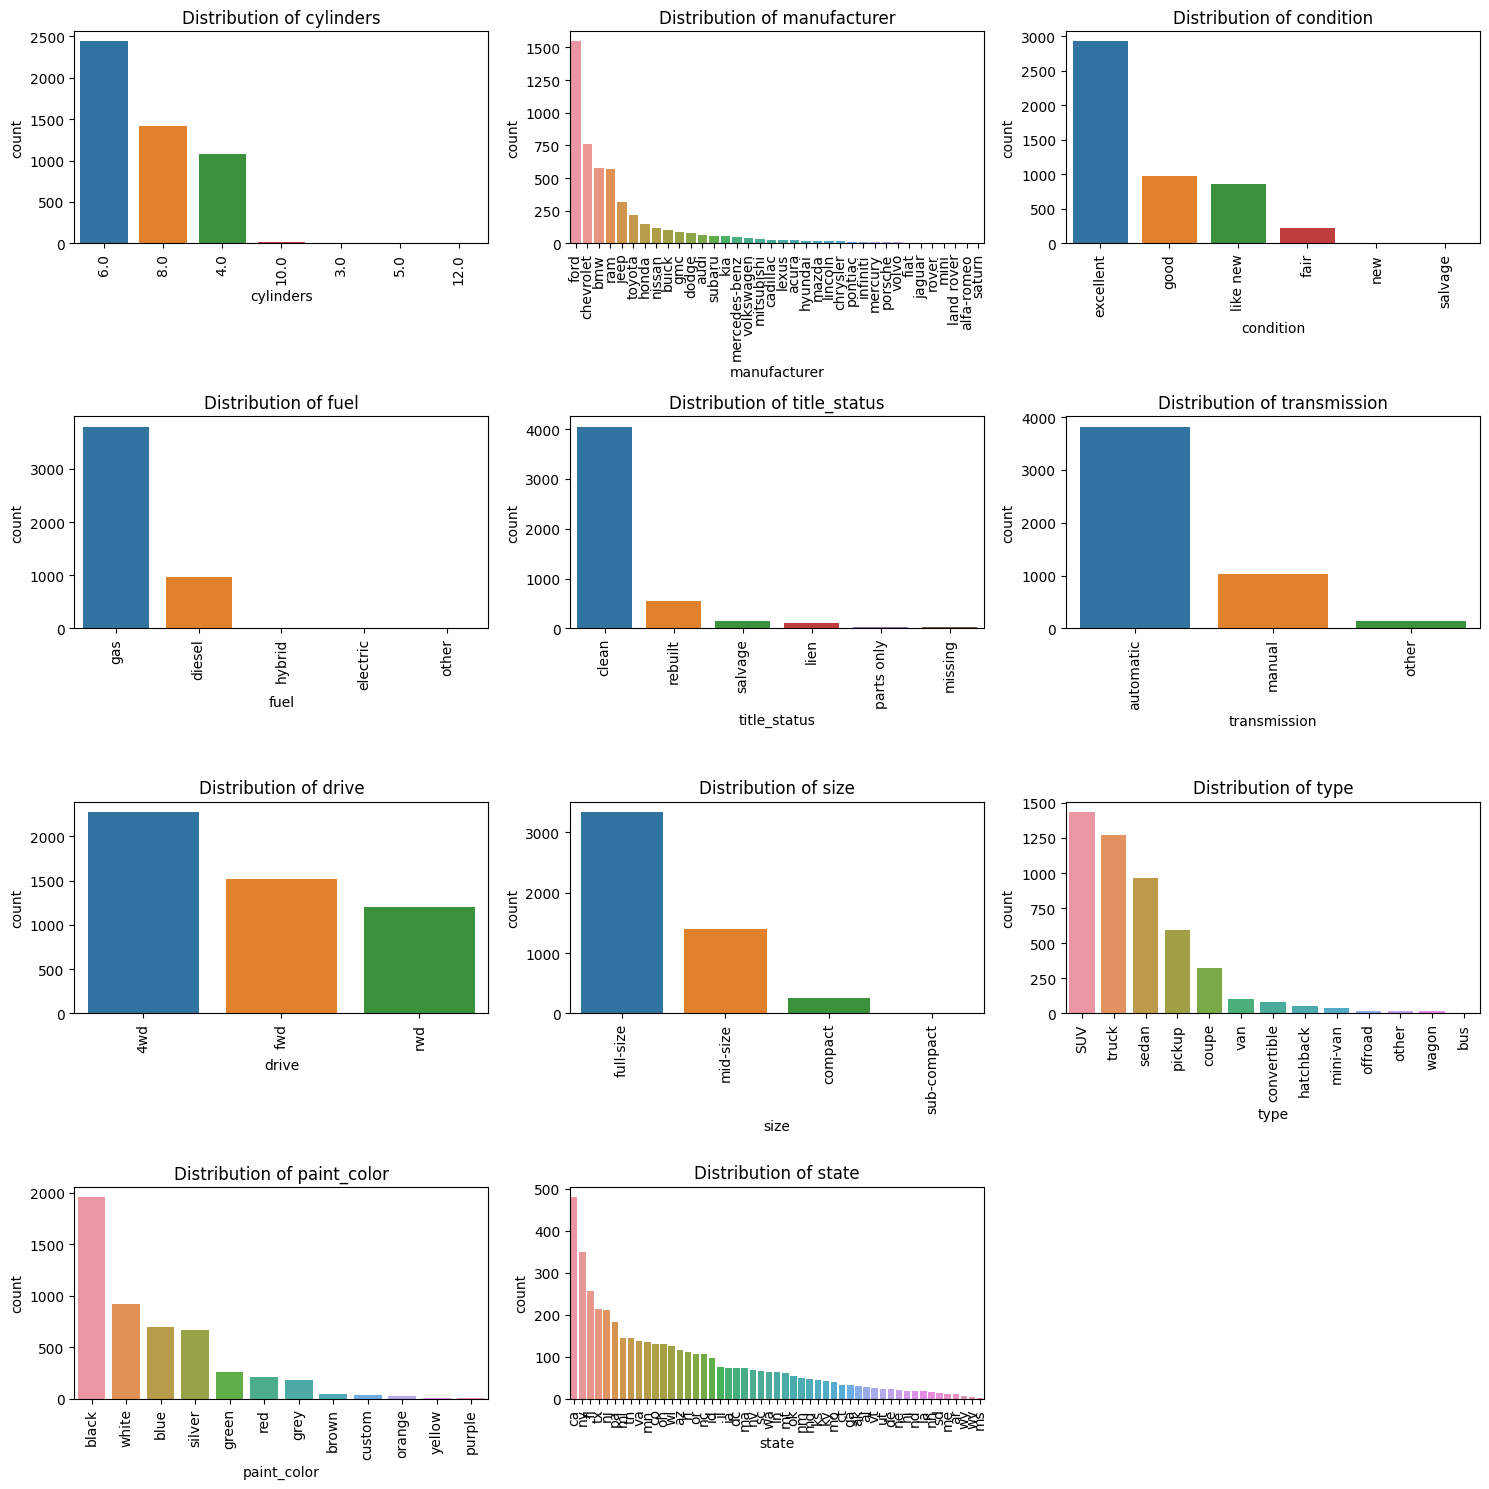

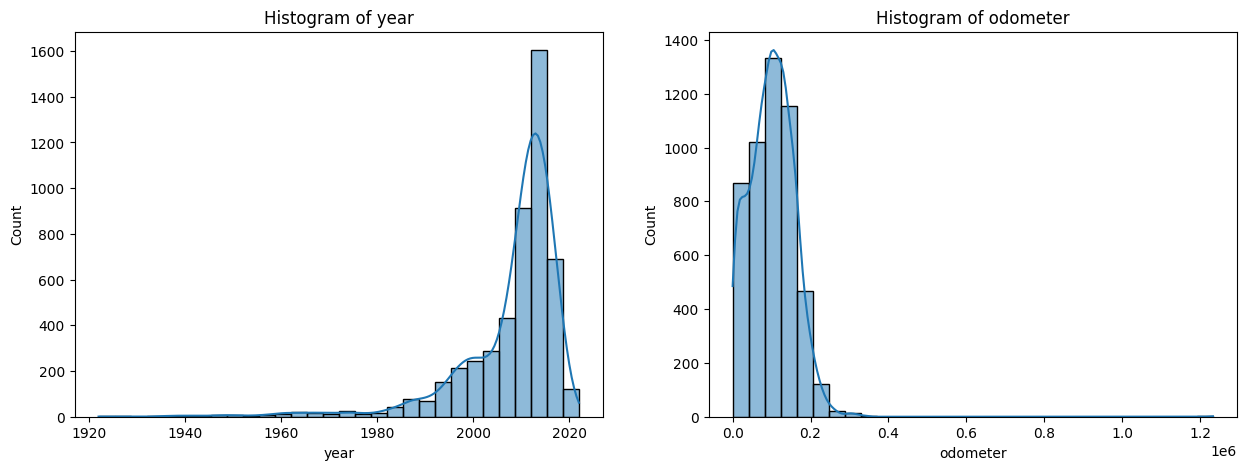

In [ ]:
import matplotlib.pyplot as plt

# Define categorical and numeric features
categorical_features = [
    "cylinders",
    "manufacturer",
    "condition",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    "state",
]

numeric_features = ["year", "odometer"]

# Plot the distribution of categorical features
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_features, 1):
    plt.subplot(4, 3, i)
    sns.countplot(data=picked_records_df, x=col, order=picked_records_df[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# Plot the histogram of numeric features
plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(1, 2, i)
    sns.histplot(picked_records_df[col], bins=30, kde=True)
    plt.title(f"Histogram of {col}")
plt.show()


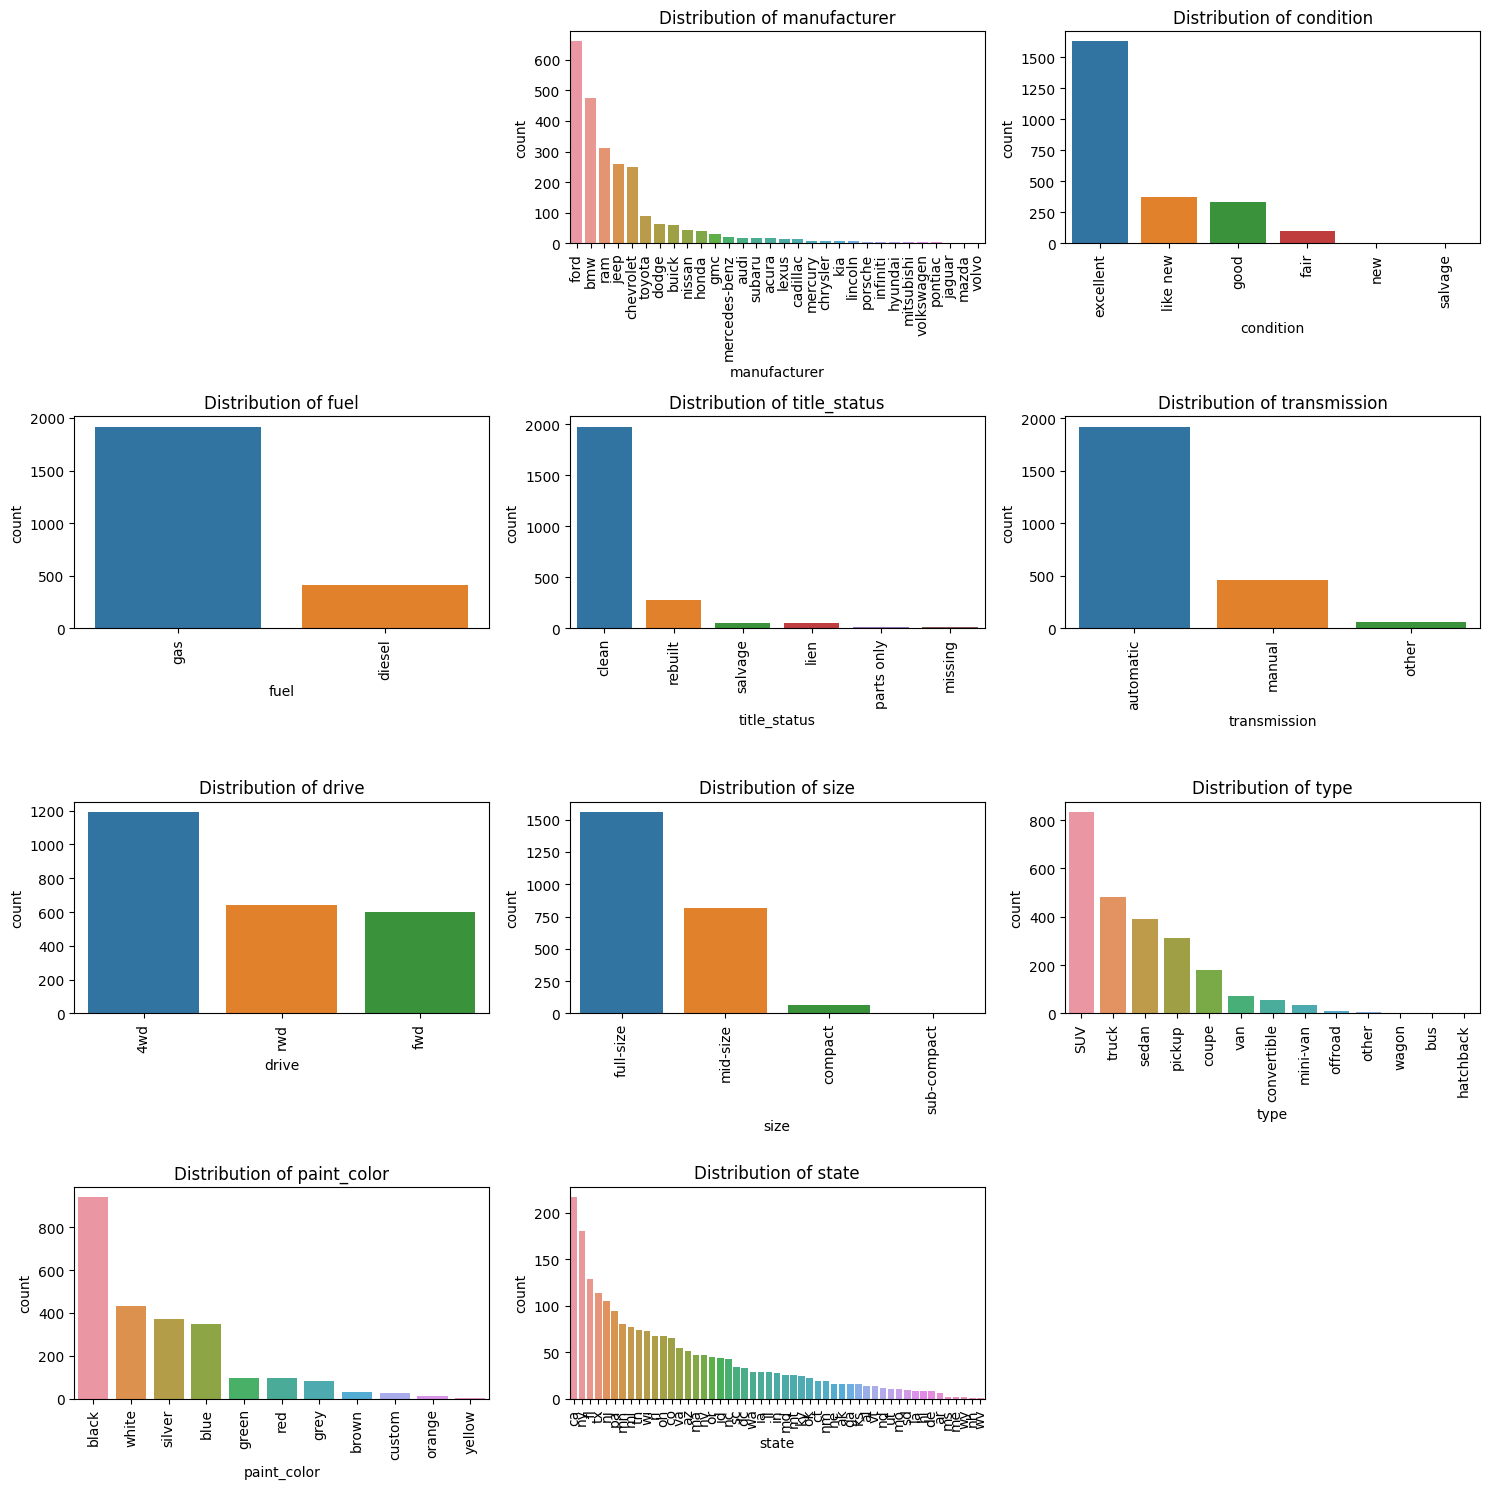

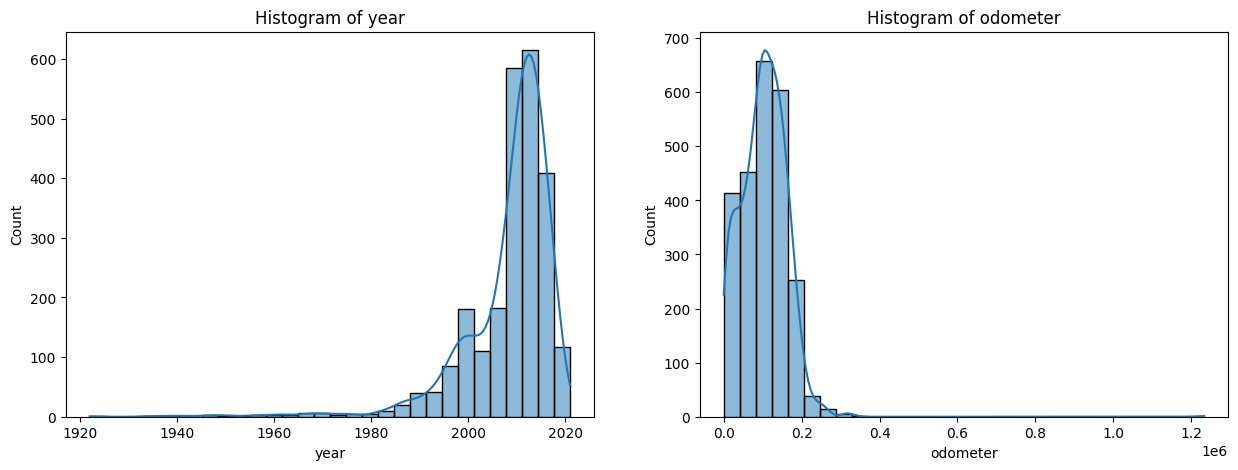

In [ ]:
# Plot the distribution of categorical features for filtered records
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_features, 1):
    if col != 'cylinders':  # Skip the 'cylinders' feature since all records have 6.0
        plt.subplot(4, 3, i)
        sns.countplot(data=filtered_records, x=col, order=filtered_records[col].value_counts().index)
        plt.xticks(rotation=90)
        plt.xlabel(col)
        plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# Plot the histogram of numeric features for filtered records
plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(1, 2, i)
    sns.histplot(filtered_records[col], bins=30, kde=True)
    plt.xlabel(col)
    plt.title(f"Histogram of {col}")
plt.show()


<ipython-input-25-ada9b0977a8e>:30: UserWarning: Glyph 12513 (\N{KATAKANA LETTER ME}) missing from current font.
  plt.tight_layout()
<ipython-input-25-ada9b0977a8e>:30: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  plt.tight_layout()
<ipython-input-25-ada9b0977a8e>:30: UserWarning: Glyph 12459 (\N{KATAKANA LETTER KA}) missing from current font.
  plt.tight_layout()
<ipython-input-25-ada9b0977a8e>:30: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  plt.tight_layout()
<ipython-input-25-ada9b0977a8e>:30: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.tight_layout()
<ipython-input-25-ada9b0977a8e>:30: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  plt.tight_layout()
<ipython-input-25-ada9b0977a8e>:30: UserWarning: Glyph 12467 (\N{KATAKANA LETTER KO}) missing from current font.
  plt.tight_layout()
<ipython-input-25-ada9b097

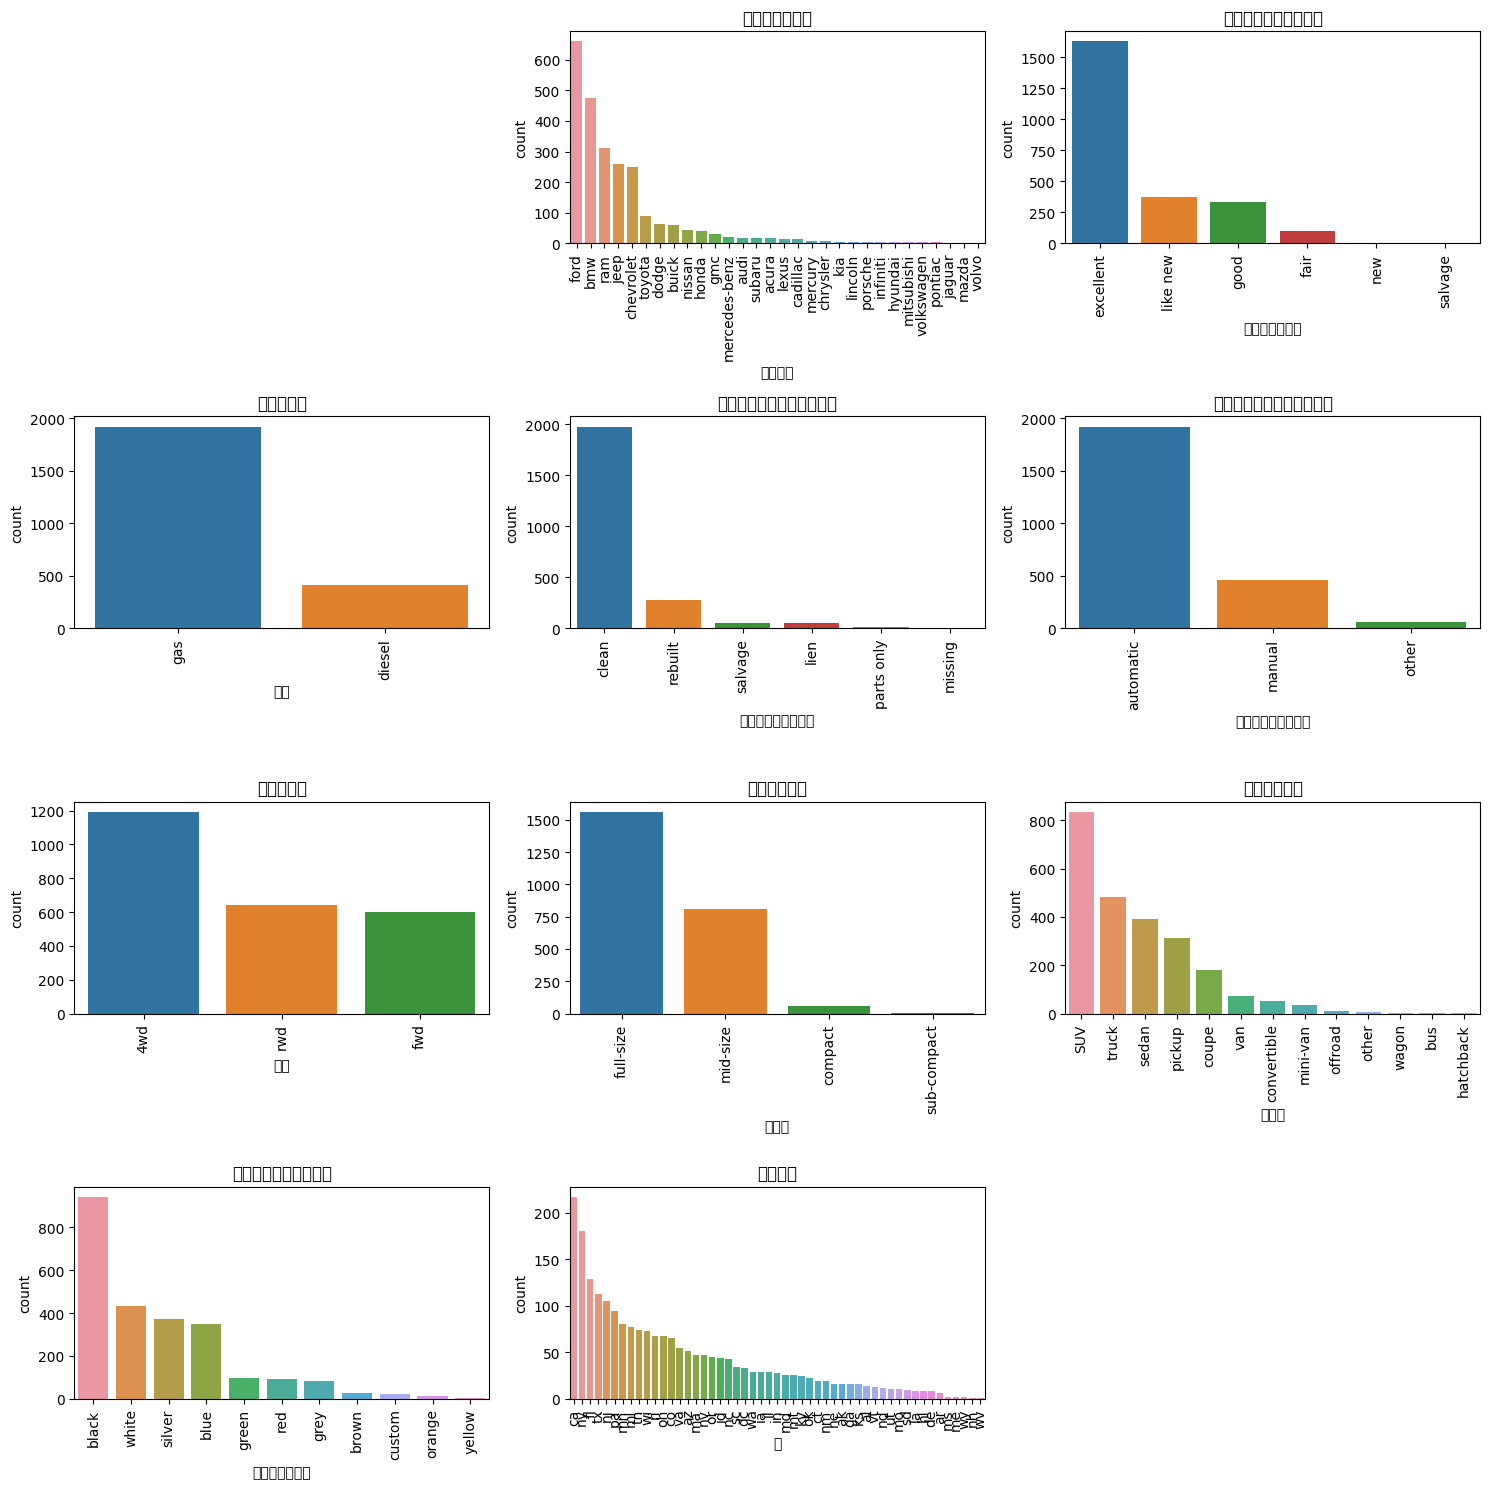

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12498 (\N{KATAKANA LETTER HI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packag

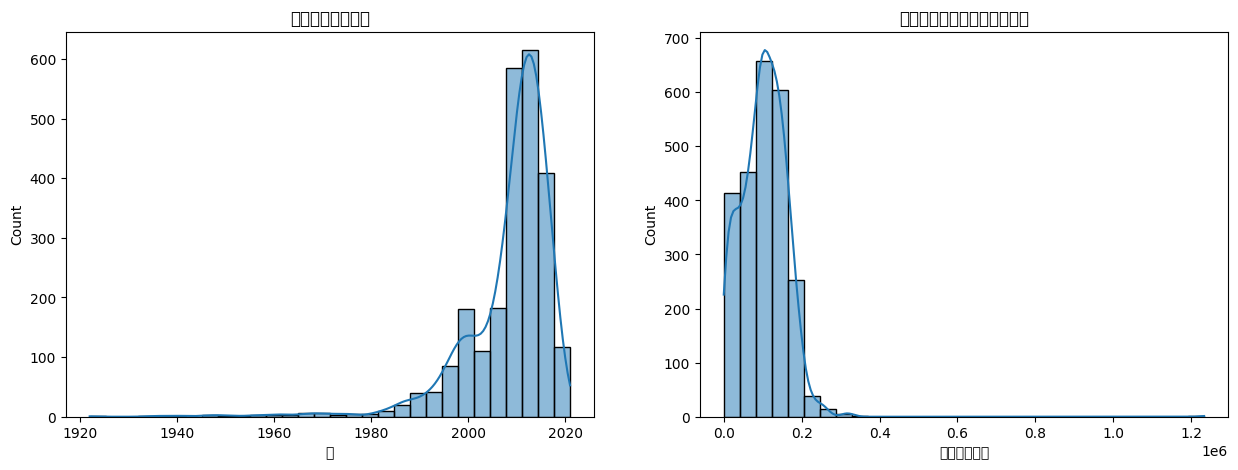

In [ ]:
# Define Japanese labels for categorical and numeric features
categorical_japanese_labels = {
    "cylinders": "シリンダー",
    "manufacturer": "メーカー",
    "condition": "コンディション",
    "fuel": "燃料",
    "title_status": "タイトルステータス",
    "transmission": "トランスミッション",
    "drive": "駆動",
    "size": "サイズ",
    "type": "タイプ",
    "paint_color": "ペイントカラー",
    "state": "州",
}

numeric_japanese_labels = {
    "year": "年",
    "odometer": "オドメーター",
}

# Plot the distribution of categorical features for filtered records
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_features, 1):
    if col != 'cylinders':  # Skip the 'cylinders' feature since all records have 6.0
        plt.subplot(4, 3, i)
        sns.countplot(data=filtered_records, x=col, order=filtered_records[col].value_counts().index)
        plt.xticks(rotation=90)
        plt.xlabel(categorical_japanese_labels[col])
        plt.title(f"{categorical_japanese_labels[col]}の分布")
plt.tight_layout()
plt.show()

# Plot the histogram of numeric features for filtered records
plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(1, 2, i)
    sns.histplot(filtered_records[col], bins=30, kde=True)
    plt.xlabel(numeric_japanese_labels[col])
    plt.title(f"{numeric_japanese_labels[col]}のヒストグラム")
plt.show()


In [ ]:
# Display all unique categories of the 'cylinders' feature
unique_cylinders = train_df['cylinders'].unique()
print("Unique categories of 'cylinders':", unique_cylinders)


Unique categories of 'cylinders': [ 6.  8.  4. nan 10. 12.  5.  3.]


In [28]:
# Filter the records where cylinders is 12.0
filtered_records_12 = picked_records_df[picked_records_df['cylinders'] == 12.0]

# Display the filtered records
print(filtered_records_12)


       Actual Price  Predicted Price  Absolute Difference     id  \
17884         32665          11756.3              20908.7  17884   
8052          37359          19665.4              17693.6   8052   
14039         29945          12482.2              17462.8  14039   
10380         24900           7529.3              17370.7  10380   
8950          22737           5609.9              17127.1   8950   
11026         25696           9165.0              16531.0  11026   
89            16507           4242.3              12264.7     89   

                   region  year   manufacturer  condition  cylinders fuel  \
17884        st augustine  1990  mercedes-benz       good       12.0  gas   
8052       ventura county  2014  mercedes-benz  excellent       12.0  gas   
14039    north central FL  1981  mercedes-benz   like new       12.0  gas   
10380                york  1998  mercedes-benz       good       12.0  gas   
8950          bakersfield  2006  mercedes-benz   like new       12.0  

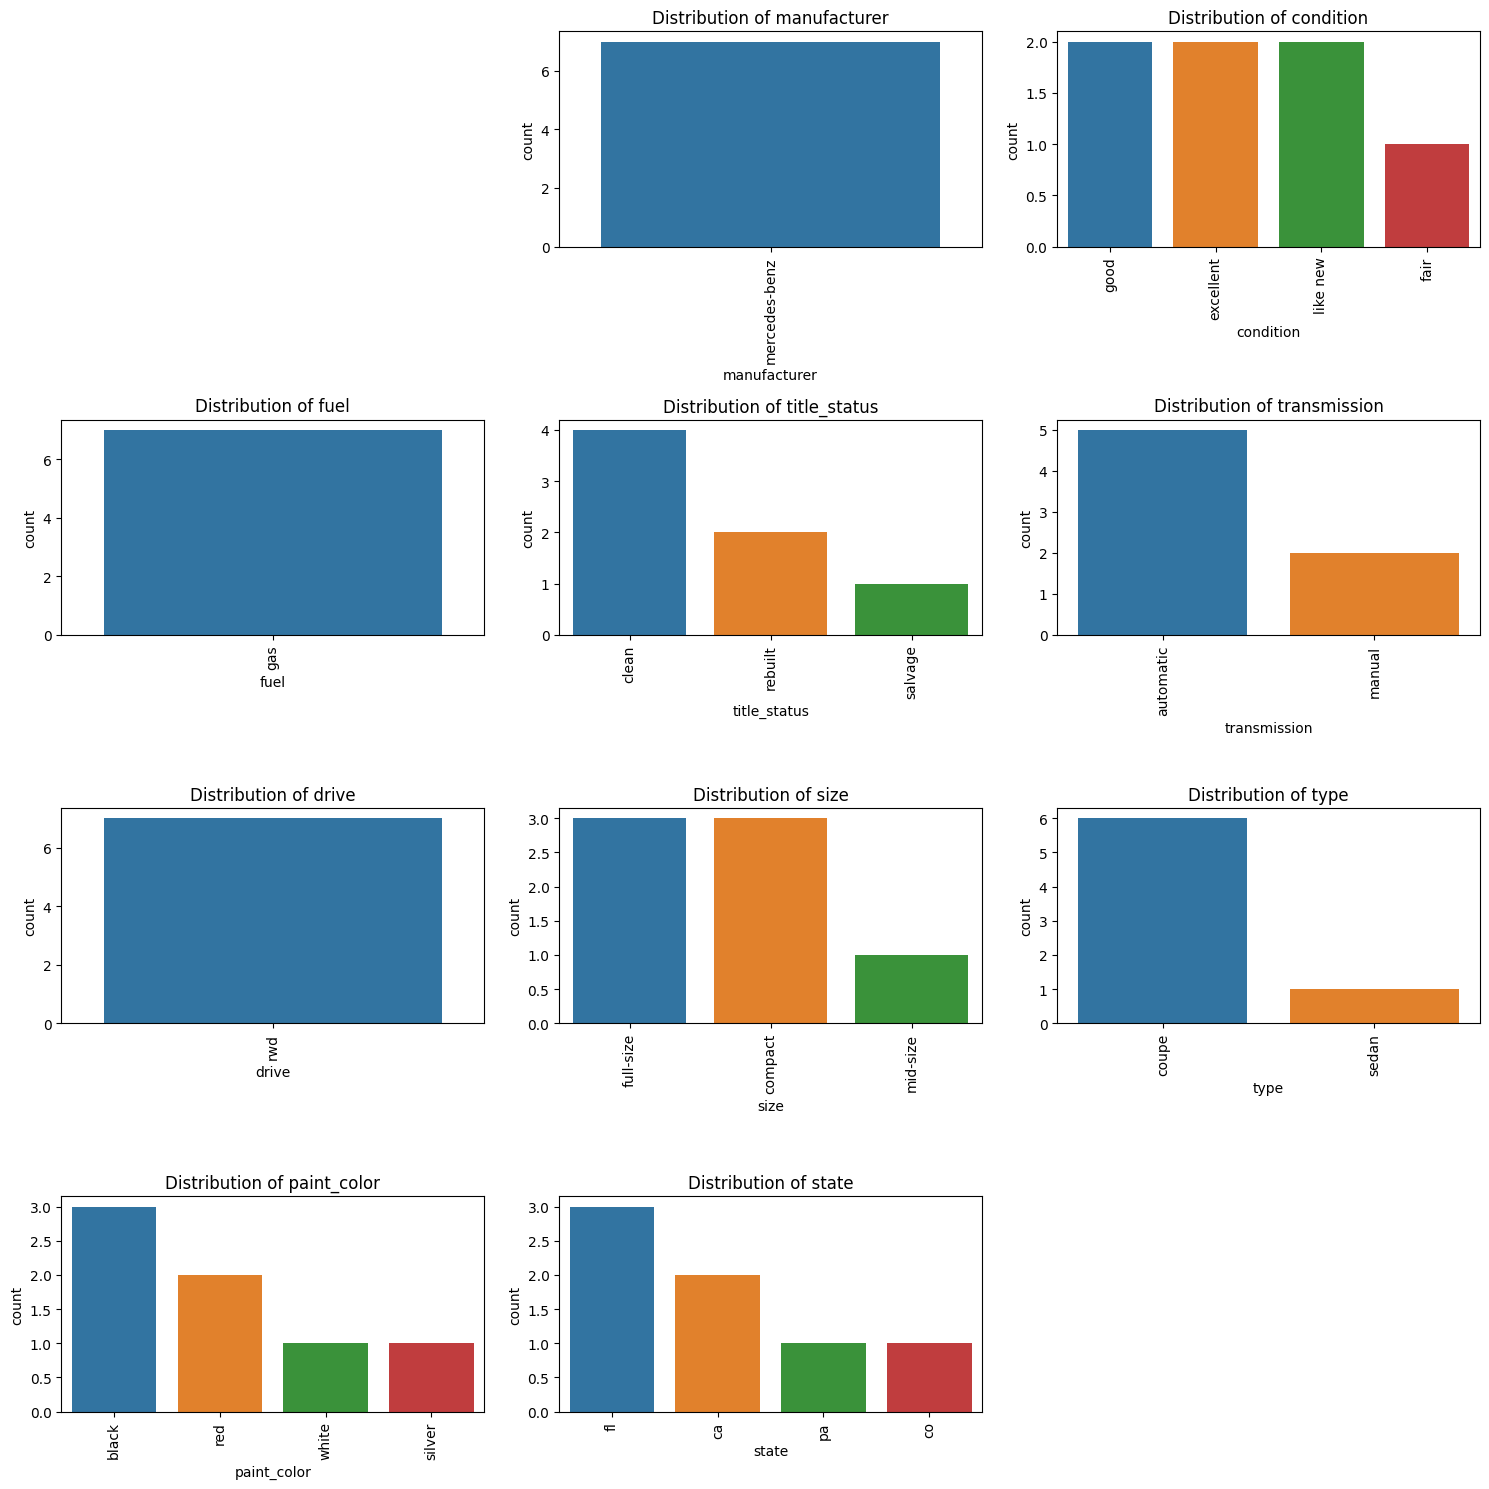

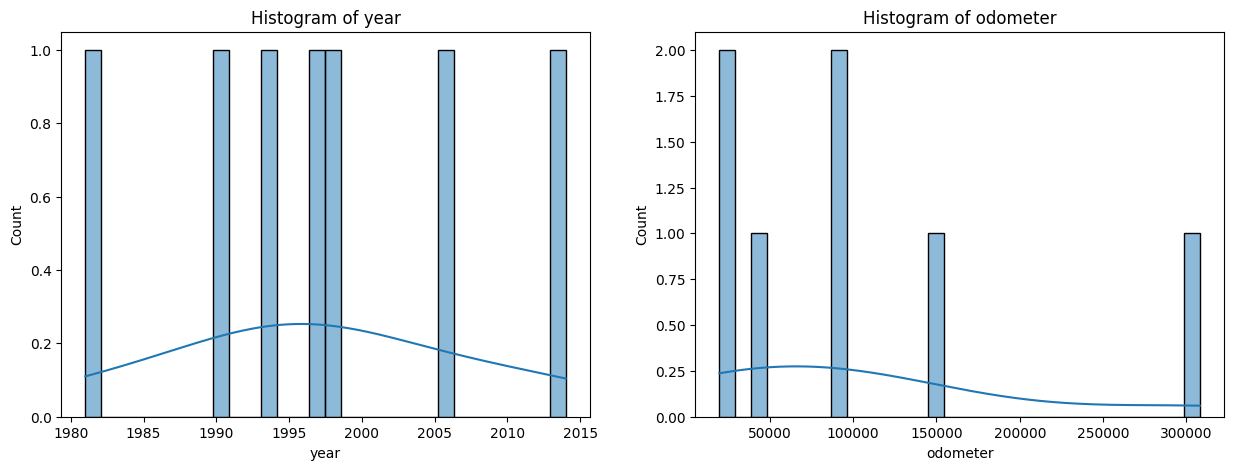

In [29]:
# Plot the distribution of categorical features for filtered records
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_features, 1):
    if col != 'cylinders':  # Skip the 'cylinders' feature since all records have 12.0
        plt.subplot(4, 3, i)
        sns.countplot(data=filtered_records_12, x=col, order=filtered_records_12[col].value_counts().index)
        plt.xticks(rotation=90)
        plt.xlabel(col)
        plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# Plot the histogram of numeric features for filtered records
plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(1, 2, i)
    sns.histplot(filtered_records_12[col], bins=30, kde=True)
    plt.xlabel(col)
    plt.title(f"Histogram of {col}")
plt.show()


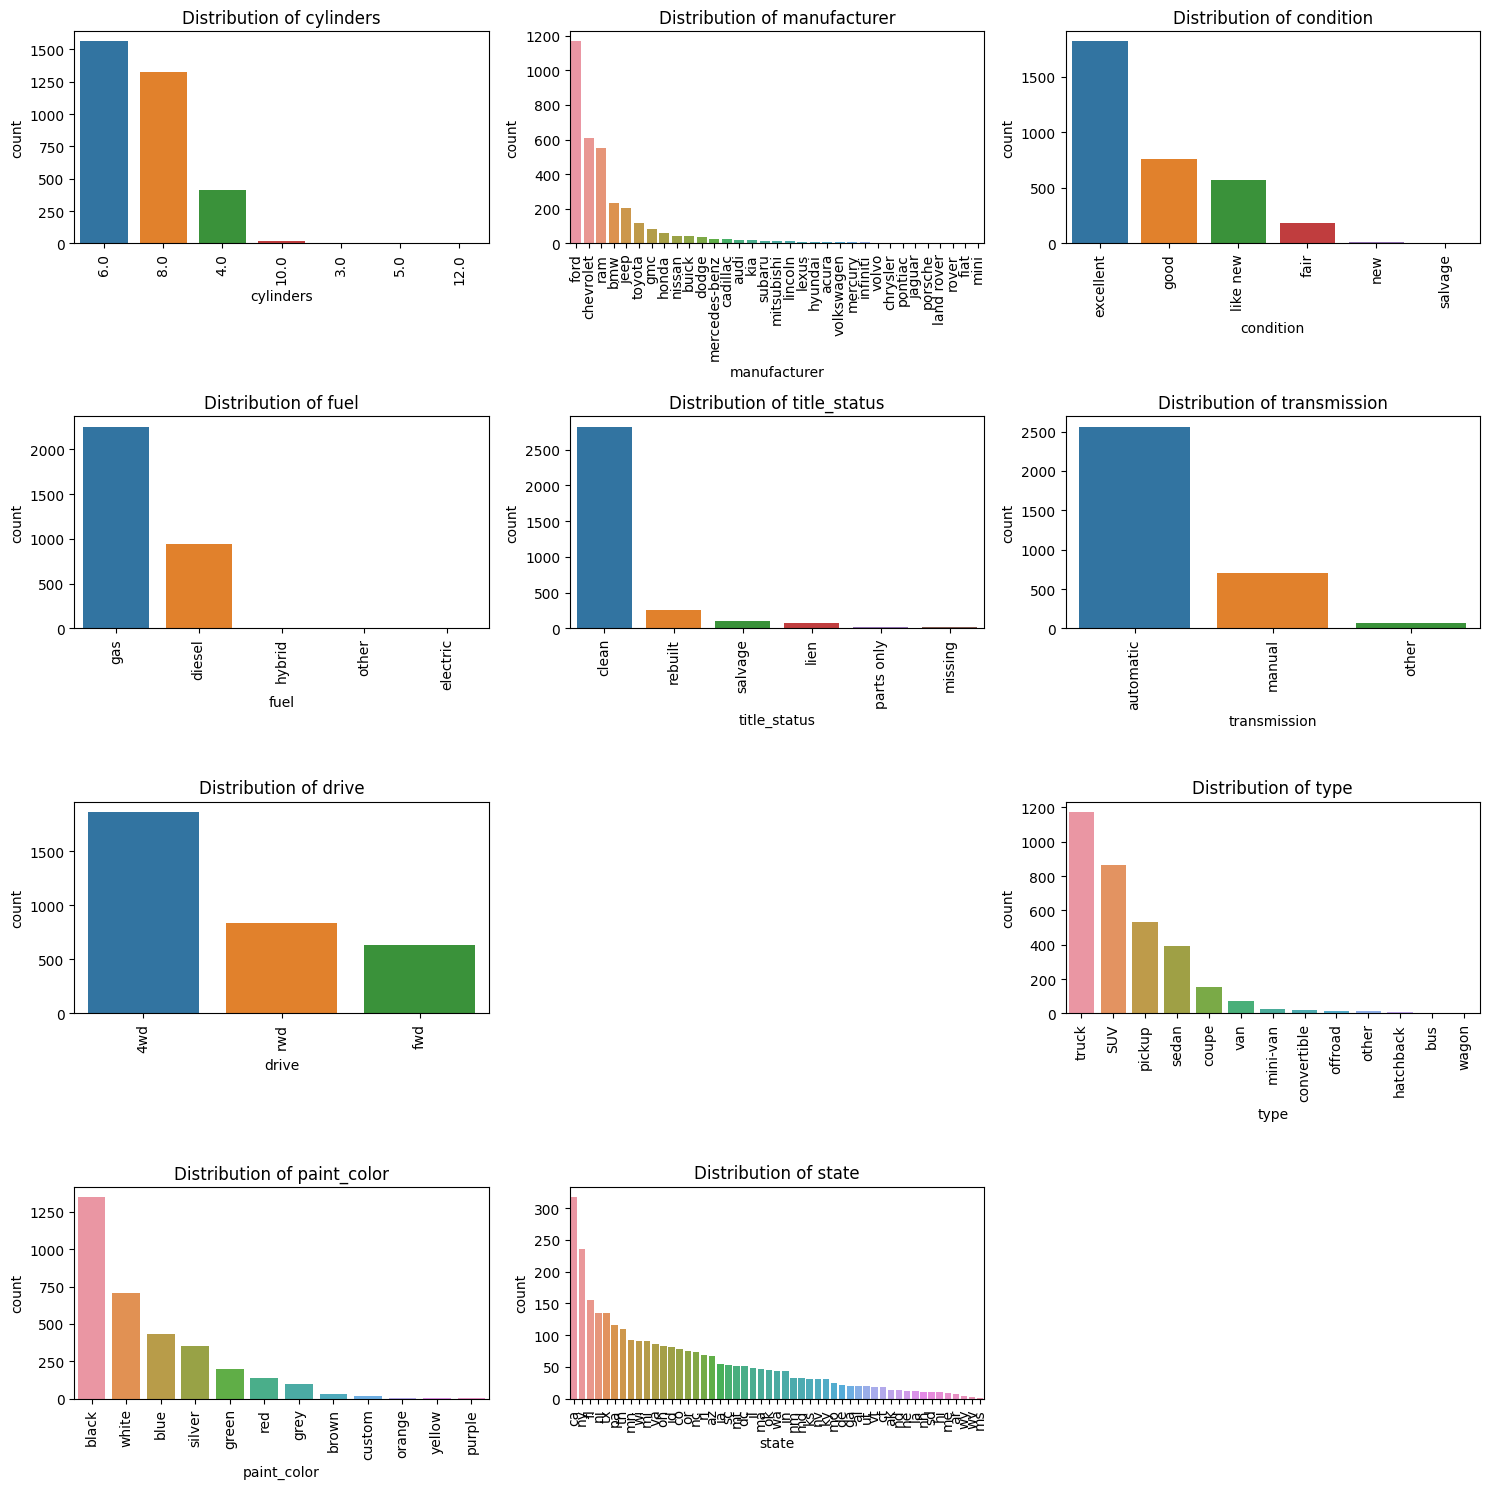

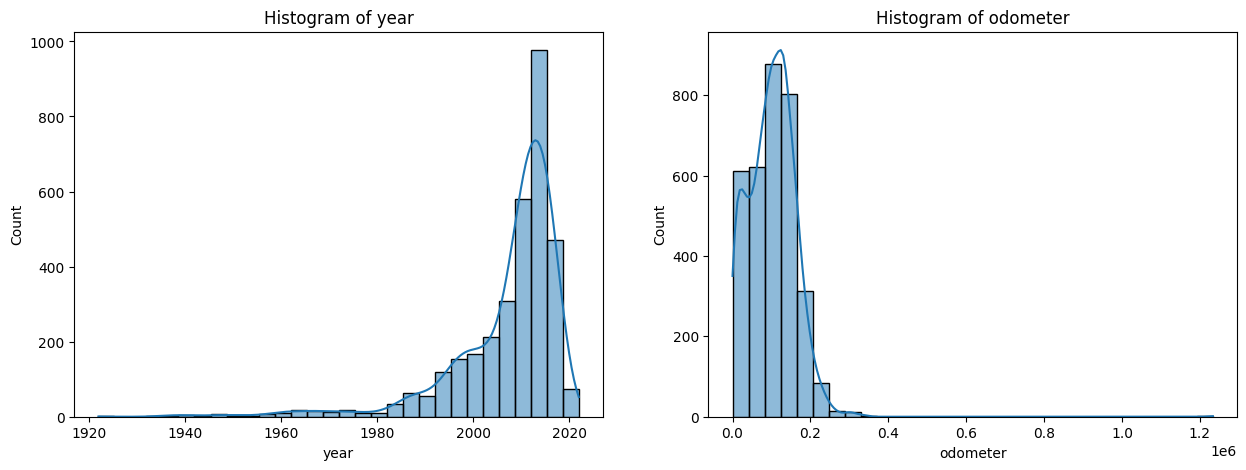

In [30]:
# Filter the records where size is 'full-size'
filtered_records_fullsize = picked_records_df[picked_records_df['size'] == 'full-size']

# Plot the distribution of categorical features for filtered records
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_features, 1):
    if col != 'size':  # Skip the 'size' feature since all records have 'full-size'
        plt.subplot(4, 3, i)
        sns.countplot(data=filtered_records_fullsize, x=col, order=filtered_records_fullsize[col].value_counts().index)
        plt.xticks(rotation=90)
        plt.xlabel(col)
        plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# Plot the histogram of numeric features for filtered records
plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(1, 2, i)
    sns.histplot(filtered_records_fullsize[col], bins=30, kde=True)
    plt.xlabel(col)
    plt.title(f"Histogram of {col}")
plt.show()
